In [12]:
%env JAX_PLATFORM_NAME=cuda

from warnings import simplefilter


simplefilter("ignore", category=FutureWarning)

from functools import partial

import diffrax
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax
from jaxtyping import Array


jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=4, suppress=True)

env: JAX_PLATFORM_NAME=cuda


# Advanced SDE example

We will be simulating a Stratonovich SDE of the form:

$$
    dy(t) = f(y(t), t) dt + g(y(t), t) \circ dw(t), 
$$

where $t \in [0, T]$, $y(t) \in \mathbb{R}^e$, and $w$ is a standard Brownian motion on $\mathbb{R}^d$. We refer to $f: \mathbb{R}^e \times [0, T] \to \mathbb{R}^e$ as the drift vector field and $g: \mathbb{R}^e \times [0, T] \to \mathbb{R}^{e \times d}$ is the diffusion matrix field. The Stratonovich integral is denoted by $\circ$.

Our SDE will have the following drift and diffusion terms:

\begin{align*}
    f(y(t), t) &= \alpha - \beta y(t), \\
    g(y(t), t) &= \gamma \begin{bmatrix} \Vert y(t) \Vert_2 & 0 \\ 0 & y_1(t) \\ 0 & 10t \end{bmatrix},
\end{align*}

where $\alpha, \gamma \in \mathbb{R}^3$ and $\beta \in \mathbb{R}_{\geq 0}$ are some parameters.

Let's write the SDE in the form that Diffrax expects:

In [2]:
# Drift VF (e = 3)
def f(t, y, args):
    alpha, beta, gamma = args
    beta = jnp.abs(beta)
    assert alpha.shape == (3,)
    return jnp.array(alpha - beta * y, dtype=y.dtype)


# Diffusion matrix field (e = 3, d = 2)
def g(t, y, args):
    alpha, beta, gamma = args
    assert gamma.shape == y.shape == (3,)
    gamma = jnp.reshape(gamma, (3, 1))
    out = gamma * jnp.array(
        [[jnp.sqrt(jnp.sum(y**2)), 0.0], [0.0, 3 * y[0]], [0.0, 20 * t]], dtype=y.dtype
    )
    return out


# Initial condition
y0 = jnp.array([1.0, 1.0, 1.0])

# Args
alpha = 0.5 * jnp.ones((3,))
beta = 1.0
gamma = jnp.ones((3,))
args = (alpha, beta, gamma)

# Time domain
t0 = 0.0
t1 = 2.0
dt0 = 2**-9

## Brownian motion and its Levy area

Different solvers require different information about the Brownian motion. For example, the `SPaRK` solver requires access to the space-time Levy area of the Brownian motion. The required Levy area for each solver is documented in the table at the end of this notebook, or can be checked via `solver.minimal_levy_area`.
 
We will use the `VirtualBrownianTree` class to generate the Brownian motion and its Levy area.

In [3]:
# check minimal levy area
solver = diffrax.SPaRK()
print(f"Minimal levy area for SPaRK: {solver.minimal_levy_area}.")

# Brownian motion
key = jr.key(0)
bm_tol = 2**-13
bm_shape = (2,)
bm = diffrax.VirtualBrownianTree(
    t0, t1, bm_tol, bm_shape, key, levy_area=diffrax.SpaceTimeLevyArea
)

# Defining the terms of the SDE
ode_term = diffrax.ODETerm(f)
diffusion_term = diffrax.ControlTerm(g, bm)  # Note that the BM is baked into the term
terms = diffrax.MultiTerm(ode_term, diffusion_term)

Minimal levy area for SPaRK: <class 'diffrax._custom_types.AbstractSpaceTimeLevyArea'>.


### Using `diffrax.diffeqsolve` to solve the SDE

We will first use constant steps of size $h = 2^{-9}$ to solve the SDE. It is very important to have $h > \mathtt{bm\_tol}$, where $\mathtt{bm\_tol}$ is the tolerance of the Brownian motion. This is important because the output distribution of the VirtualBrownianTree is precise as long as the times that we sample it at are at least $\mathtt{bm\_tol}$ apart. For more details see the [Single-seed Brownian Motion paper](https://arxiv.org/abs/2405.06464).

 We will use the SPaRK solver to solve the SDE. SPaRK is a stochastic Runge-Kutta method that requires access to space-time Levy area.

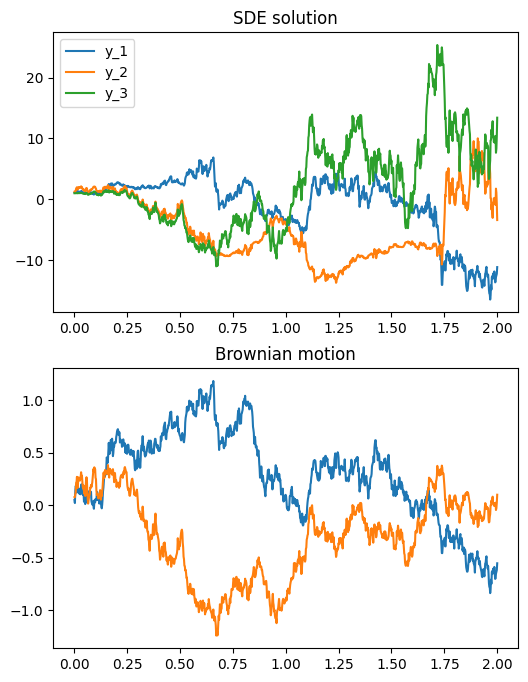

In [4]:
sol = diffrax.diffeqsolve(
    terms, diffrax.SPaRK(), t0, t1, dt0, y0, args, saveat=diffrax.SaveAt(steps=True)
)

# Plotting the solution on ax1 and the BM on ax2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
ax1.plot(sol.ts, sol.ys[:, 0], label="y_1")
ax1.plot(sol.ts, sol.ys[:, 1], label="y_2")
ax1.plot(sol.ts, sol.ys[:, 2], label="y_3")
ax1.set_title("SDE solution")
ax1.legend()

bm_vals = jax.vmap(lambda t: bm.evaluate(t0, t))(jnp.clip(sol.ts, t0, t1))
ax2.plot(sol.ts, bm_vals[:, 0], label="BM_1")
ax2.plot(sol.ts, bm_vals[:, 1], label="BM_2")
ax2.set_title("Brownian motion")

plt.show()

## Using adaptive time-stepping via the PID-controller

In order to use adaptive time stepping, the solver must produce an estimate of its error on each step. This is then used by the PID controller to adjust the step size.
To perform this error estimation the `SPaRK` solver uses an embedded method. For solvers like `GeneralShARK`, which do not have an embedded method, we'd instead need to use `HalfSolver(GeneralShARK())` as the solver in order to estimate the error.

Accepted steps: 2462, Rejected steps: 1500, total steps: 3962


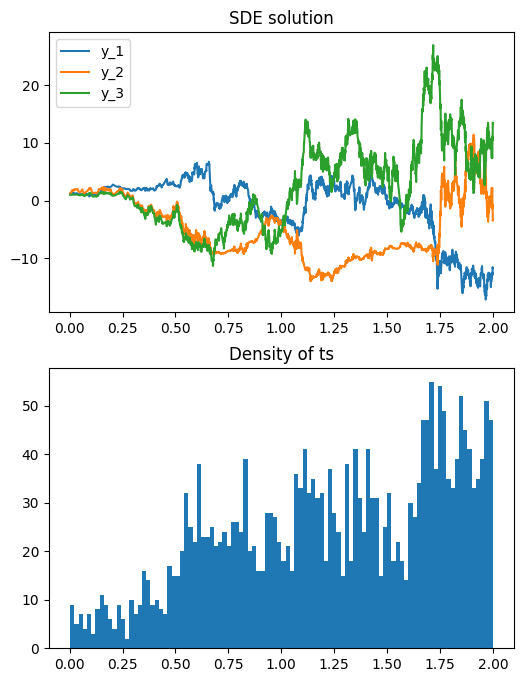

In [5]:
controller = diffrax.PIDController(
    rtol=0,
    atol=0.005,
    pcoeff=0.2,
    icoeff=0.5,
    dcoeff=0,
    dtmin=2**-12,
    dtmax=0.25,
)

solver = diffrax.SPaRK()
# solver = diffrax.HalfSolver(diffrax.GeneralShARK())

sol_pid_spark = diffrax.diffeqsolve(
    terms,
    solver,
    t0,
    t1,
    dt0,
    y0,
    args,
    saveat=diffrax.SaveAt(steps=True),
    stepsize_controller=controller,
    max_steps=2**16,
)
accepted_steps = sol_pid_spark.stats["num_accepted_steps"]
rejected_steps = sol_pid_spark.stats["num_rejected_steps"]
print(
    f"Accepted steps: {accepted_steps}, Rejected steps: {rejected_steps},"
    f" total steps: {accepted_steps + rejected_steps}"
)

# Plot the solution on ax1 and the density of ts on ax2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
ax1.plot(sol_pid_spark.ts, sol_pid_spark.ys[:, 0], label="y_1")
ax1.plot(sol_pid_spark.ts, sol_pid_spark.ys[:, 1], label="y_2")
ax1.plot(sol_pid_spark.ts, sol_pid_spark.ys[:, 2], label="y_3")
ax1.set_title("SDE solution")
ax1.legend()

# Plot the density of ts
# sol_pid.ts is padded with inf values at the end, so we remove them
padding_idx = jnp.argmax(jnp.isinf(sol_pid_spark.ts))
ts = sol_pid_spark.ts[:padding_idx]
ax2.hist(ts, bins=100)
ax2.set_title("Density of ts")

plt.show()

## Solving an SDE for a batch of Brownian motions

When doing Monte Carlo simulations, we often need to solve the same SDE for multiple Brownian motions. We can do this via `jax.vmap`.

In [16]:
def get_terms(bm):
    return diffrax.MultiTerm(ode_term, diffrax.ControlTerm(g, bm))


# Fix which times we step to (this is equivalent to a constant step size)
# We do this because the combination of using dt0 and SaveAt(steps=True) pads the
# output with inf values up to max_steps.
# Instead we specify exactly which times we want to save at, so Diffrax allocates
# the correct amount of memory at the outset.
num_steps = 2**8
step_times = jnp.linspace(t0, t1, num_steps + 1, endpoint=True)
constant_controller = diffrax.StepTo(ts=step_times)
saveat = diffrax.SaveAt(ts=step_times)


# We will vmap over keys
@eqx.filter_jit
@partial(jax.vmap, in_axes=(0, None, None))
def batch_sde_solve(key, saveat, args):
    bm = diffrax.VirtualBrownianTree(
        t0, t1, bm_tol, bm_shape, key, levy_area=diffrax.SpaceTimeLevyArea
    )
    terms = get_terms(bm)
    return diffrax.diffeqsolve(
        terms,
        diffrax.SPaRK(),
        t0,
        t1,
        None,
        y0,
        args,
        saveat=saveat,
        stepsize_controller=constant_controller,
    )


# Split the keys and compute the batched solutions
num_samples = 100
keys = jr.split(jr.PRNGKey(0), num_samples)

In [17]:
batch_sols = batch_sde_solve(keys, saveat, args)
print(
    f"Shape of batch_sols: "
    f"{batch_sols.ys.shape} == {num_samples} x {num_steps + 1} x (dim of y)"
)

Shape of batch_sols: (100, 257, 3) == 100 x 257 x (dim of y)


## Optimizing wrt. SDE parameters
We will optimize the SDE parameters with the aim of achieving a mean of 0 and variance 4 at time `t1`.

In [18]:
saveat_t1 = diffrax.SaveAt(t1=True)
batch_ys = batch_sde_solve(keys, saveat_t1, args).ys
print(batch_ys.shape)
ys_t1 = batch_ys[:, 0]
mean_t1 = jnp.mean(ys_t1, axis=0)
var_t1 = jnp.mean(ys_t1**2, axis=0) - mean_t1**2
print(f"Stats at t=t1: mean={mean_t1}, var={var_t1}")


# We will optimize for achieving a mean of 0
def loss(args: tuple[Array, Array, Array]):
    _batch_sols = batch_sde_solve(keys, saveat_t1, args)
    batch_ys = _batch_sols.ys
    assert batch_ys.shape == (num_samples, 1, 3)
    mean = jnp.mean(batch_ys, axis=(0, 1))
    std = jnp.sqrt(jnp.mean(batch_ys**2, axis=(0, 1)) - mean**2)
    target_mean = jnp.array([0.0, 1.0, 0.0])
    target_stds = 2 * jnp.ones((3,))
    loss = jnp.sqrt(
        jnp.sum((mean - target_mean) ** 2) + jnp.sum((std - target_stds) ** 2)
    )
    return loss


# Define the parameters to optimize
alpha_opt = 0.5 * jnp.ones((3,))
beta_opt = jnp.array(1.0)
gamma_opt = jnp.ones((3,))
args_opt = (alpha_opt, beta_opt, gamma_opt)

# Define the optimizer
num_steps = 191
schedule = optax.cosine_decay_schedule(3e-1, num_steps, 1e-2)
opt = optax.chain(
    optax.scale_by_adam(b1=0.9, b2=0.99, eps=1e-8),
    optax.scale_by_schedule(schedule),
    optax.scale(-1),
)
# opt = optax.adam(2e-1)
opt_state = opt.init(args_opt)


@jax.jit
def step(i, opt_state, args):
    loss_val, grad = jax.value_and_grad(loss)(args)
    updates, opt_state = opt.update(grad, opt_state)

    # One way to apply updates
    # args = optax.apply_updates(args, updates)

    # Another way to apply updates
    args = jax.tree_util.tree_map(lambda x, u: x + u, args, updates)

    return opt_state, args, loss_val


for i in range(num_steps):
    opt_state, args_opt, loss_val = step(i, opt_state, args_opt)
    alpha_opt, beta_opt, gamma_opt = args_opt
    if i % 10 == 0:
        print(f"Step {i}, loss: {loss_val}")

print(
    f"Optimal parameters:\n"
    f"alpha={alpha_opt},"
    f" beta={beta_opt}, gamma={gamma_opt}"
)

(100, 1, 3)
Stats at t=t1: mean=[ 6.2142 -1.858   2.5538], var=[ 968.0161 1816.357   490.2578]
Step 0, loss: 54.37318141670484
Step 10, loss: 6.744215098806366
Step 20, loss: 2.998366856582221
Step 30, loss: 1.2659615064637102
Step 40, loss: 0.9366064334115017
Step 50, loss: 0.5297932248566202
Step 60, loss: 0.2899448067097704
Step 70, loss: 0.22884998150945443
Step 80, loss: 0.3022284048251223
Step 90, loss: 0.08371389038646312
Step 100, loss: 0.19500267926433498
Step 110, loss: 0.15579142632143467
Step 120, loss: 0.21476759365188788
Step 130, loss: 0.07189106656001293
Step 140, loss: 0.06617959592505693
Step 150, loss: 0.07004904780195191
Step 160, loss: 0.016133195408697235
Step 170, loss: 0.04618817294618282
Step 180, loss: 0.014085655094219525
Step 190, loss: 0.005163943744172692
Optimal parameters:
alpha=[ 0.667   3.4642 -0.7856], beta=3.3743923144904424, gamma=[-1.3289 -0.9053  0.1391]


In [20]:
batch_ys_opt = batch_sde_solve(keys, saveat_t1, args_opt).ys
ys_t1 = batch_ys_opt[:, -1]
mean_t1 = jnp.mean(ys_t1, axis=0)
var_t1 = jnp.mean(ys_t1**2, axis=0) - mean_t1**2
print(f"Stats at t=t1: mean={mean_t1}, var={var_t1}")

Stats at t=t1: mean=[ 0.0007  0.9999 -0.0003], var=[3.9827 3.9803 3.9832]


With the magic of JAX and Diffrax we were able to differentiate through the SDE solver and optimize the parameters of the SDE to achieve the desired mean and variance at time `t1`.